We will have the hands on expereince with the neural network classification pronlem .
In order to illustrate  this , first of all lets get our data ready .


In [1]:
from sklearn.datasets import make_circles
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")


First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


**Lets organize the generated circles in the data frame**

In [2]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


under these noise , we want to see how many types of each color circle are being genrated here

In [3]:
circles.label.value_counts()


,count
label,
1,500
0,500


Intrstingly m exactly same  means both have fair shares of value .
Then lets plot this and visualize what we have got till now

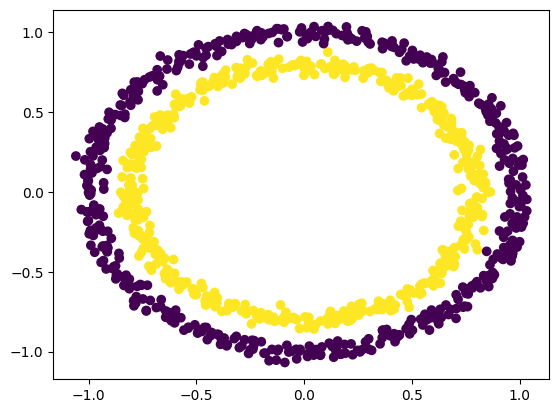

In [4]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.viridis);


Data Shape

In [5]:
X.shape, y.shape


((1000, 2), (1000,))

In [6]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


Its clear that  we are equiped with the data , now lets turn these sorts of data onto torch tensors and split them between test data and training data .

In [7]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

i encountered error in above steps , because i tried to run this code again .
this was solved while i happened to restart the sessions and run all at once.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)


(800, 200, 800, 200)

**Building a Model**

first of all lets set uo the device agnostic code

In [9]:

from torch import nn
# Detect if GPU is available for faster training. Otherwise use CPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

Lets construct the model

In [10]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # first layer
        self.layer_2 = nn.Linear(in_features=5, out_features=1)  # second layer

    def forward(self, x):
        return self.layer_2(self.layer_1(x))


the above code is self-explantory , Lets fit this model into device

In [11]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

Lets define the losss function and optimizer then

In [12]:
loss_fn = nn.BCEWithLogitsLoss()  # Good for binary classification
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)


**Trainig the model**

Lets train our model with the data , feed through loss and optimizer

In [13]:
# Suppose X_train is your input data and y_train the labels
# This will make y_train shape (800, 1) instead of (800,)
y_train = y_train.unsqueeze(1)
epochs = 100
for epoch in range(epochs):
    model_0.train()  # 1. Set model to training mode
    y_pred = model_0(X_train)  # 2. Make predictions
    loss = loss_fn(y_pred, y_train)  # 3. Calculate loss
    optimizer.zero_grad()  # 4. Reset any previous gradients
    loss.backward()  # 5. Backpropagation: compute gradients
    optimizer.step()  # 6. Update model using optimizer
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss: {loss.item():.4f}")


Epoch 0: Loss: 0.6953
Epoch 10: Loss: 0.6938
Epoch 20: Loss: 0.6933
Epoch 30: Loss: 0.6931
Epoch 40: Loss: 0.6930
Epoch 50: Loss: 0.6930
Epoch 60: Loss: 0.6930
Epoch 70: Loss: 0.6930
Epoch 80: Loss: 0.6930
Epoch 90: Loss: 0.6930


No significant decrease in losss is observed . can we increase it upto 1000.
Slight less is observed may be because we are using sgd . Using sgd is like making daily practise to improve the condition.

Any way we have to move to the evaluation phases .

In [14]:
model_0.eval()                   # 1. Set model to evaluation mode
y_test = y_test.unsqueeze(1)

with torch.no_grad():            # 2. Avoid tracking gradients
    test_pred = model_0(X_test)  # 3. Make predictions
    test_loss = loss_fn(test_pred, y_test)  # 4. Calculate loss

lets calculate the accuracy then

In [15]:
# For binary classification
pred_labels = test_pred.round()           # Turn probabilities into 0 or 1
accuracy = (pred_labels == y_test).float().mean()
print(f"Test Accuracy: {accuracy.item():.2%}")


Test Accuracy: 50.00%


Not satisfactory , just random guessing or something else ...
lets predict and plot the  graph

helper_functions.py already exists, skipping download


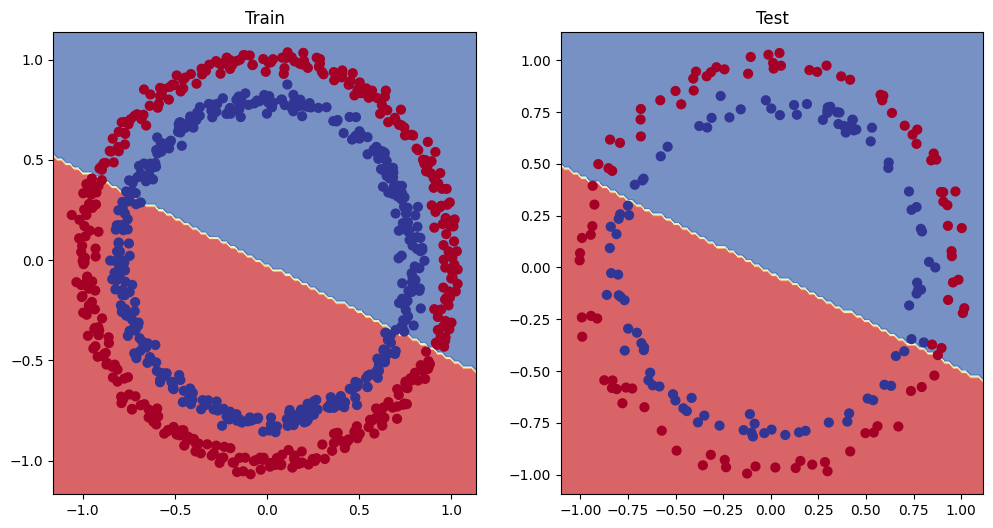

In [16]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


The model's poor performance and 50% accuracy are due to underfitting. It's attempting to separate circular data with a straight line, which is inherently ineffective. This means the model isn't adequately learning the underlying patterns in the data.

while going through the remaining chapter of this unit , i  found the limitation of this approach .  Our linear approach is too simple to grasp the reaity of this complex architecheture .   Stacking the linear layer multiple times will not solve this problem of nin-linearilty since our model remains fundamentally linear

In order to solve this problem , we need to give our model capacity to learn the non-linear pattern such the the decision boundaries of our model is extended .

For this purpose , we are introducing the non-linear activation function such that our model holds the capacity to learn the non-linear pattern also .


So for this we are using the rectified linear unit to give the capability to learn non-linear pattern .


In [17]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


Instead of seeing only in straight lines, it can now curve, bend, and wrap around your data to make much better predictions, especially on tricky tasks like separating circular or spiral patterns!

To proceed , lets set up the binary classification loss function as weell as an optimizer

In [18]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

as well as accuracy function :

In [19]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()  # Compare predictions to true labels
    acc = (correct / len(y_pred)) * 100              # Calc % accuracy
    return acc
true_labels = torch.tensor([1, 0, 1, 1])
pred_labels = torch.tensor([1, 0, 0, 1])
print(accuracy_fn(true_labels, pred_labels))  # Should print 75.0


75.0


Lets train our model with the non-linearlity then

In [28]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)).squeeze()# logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train.squeeze()) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.21384, Accuracy: 40000.00% | Test Loss: 0.25010, Test Accuracy: 99.00%
Epoch: 100 | Loss: 0.13063, Accuracy: 40000.00% | Test Loss: 0.16797, Test Accuracy: 99.00%
Epoch: 200 | Loss: 0.08500, Accuracy: 40000.00% | Test Loss: 0.11945, Test Accuracy: 99.50%
Epoch: 300 | Loss: 0.05981, Accuracy: 40000.00% | Test Loss: 0.09032, Test Accuracy: 99.50%
Epoch: 400 | Loss: 0.04465, Accuracy: 40000.00% | Test Loss: 0.07121, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.03498, Accuracy: 40000.00% | Test Loss: 0.05875, Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.02849, Accuracy: 40000.00% | Test Loss: 0.05012, Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.02390, Accuracy: 40000.00% | Test Loss: 0.04378, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.02051, Accuracy: 40000.00% | Test Loss: 0.03905, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.01788, Accuracy: 40000.00% | Test Loss: 0.03512, Test Accuracy: 100.00%


lets go through evaluation

In [29]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

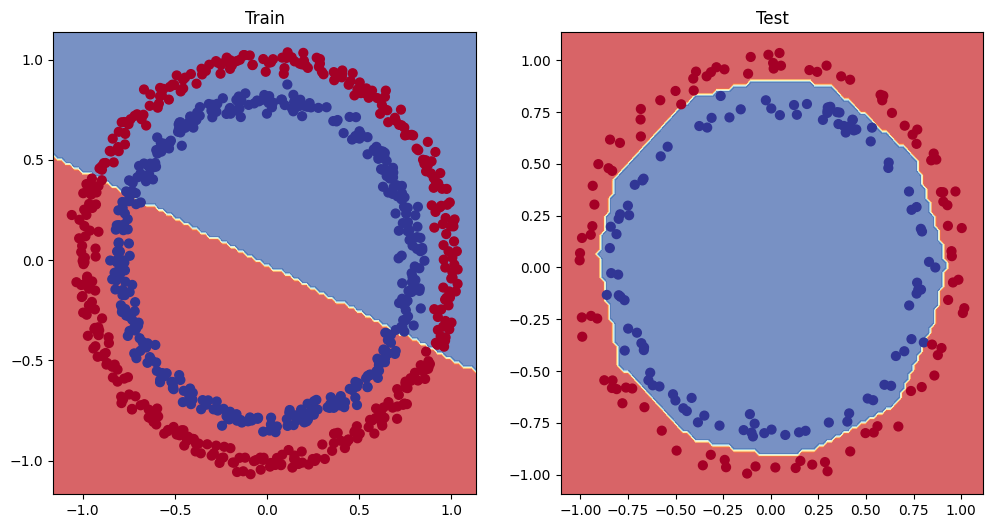

In [32]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity